In [1]:
import sys
import numpy as np
from astropy.io import fits
from astroscrappy import detect_cosmics
from matplotlib import pyplot as plt 
sys.path.append('aspired')

import twodspec
import standard

In [2]:
# Example data from SPRAT
# BDp33_2642_zpol
sprat_data = fits.open('examples/v_s_20190616_34_1_0_2.fits')[0].data


aspired/twodspec.py:103: RuntimeWarning: invalid value encountered in log10
  np.log10(img),


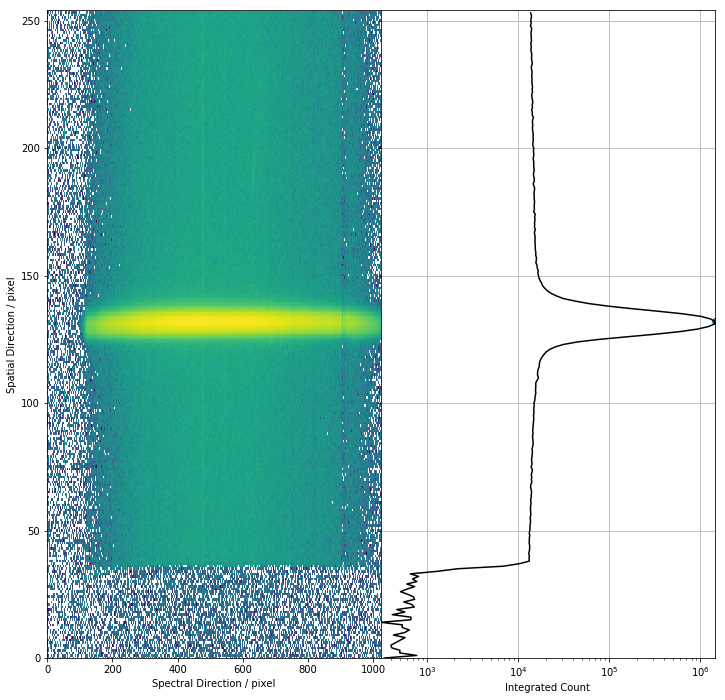

In [3]:
# (1) example of twodspec._find_peaks() with cosmic ray removal

# Set the spectral and spatial direction
Saxis = 1
Waxis = 0

# get the length in the spectral and spatial directions
spec_size = np.shape(sprat_data)[Waxis]
spatial_size = np.shape(sprat_data)[Saxis]

# the valid y-range of the chip (an array of int)
ydata = np.arange(spec_size)
ztot = np.sum(sprat_data, axis=Saxis)

peaks_y, heights_y = twodspec._find_peaks(detect_cosmics(sprat_data)[1], spec_size, spatial_size, ydata, ztot, f_height=0.2, display=True)

aspired/twodspec.py:321: RuntimeWarning: invalid value encountered in log10
  np.log10(img),


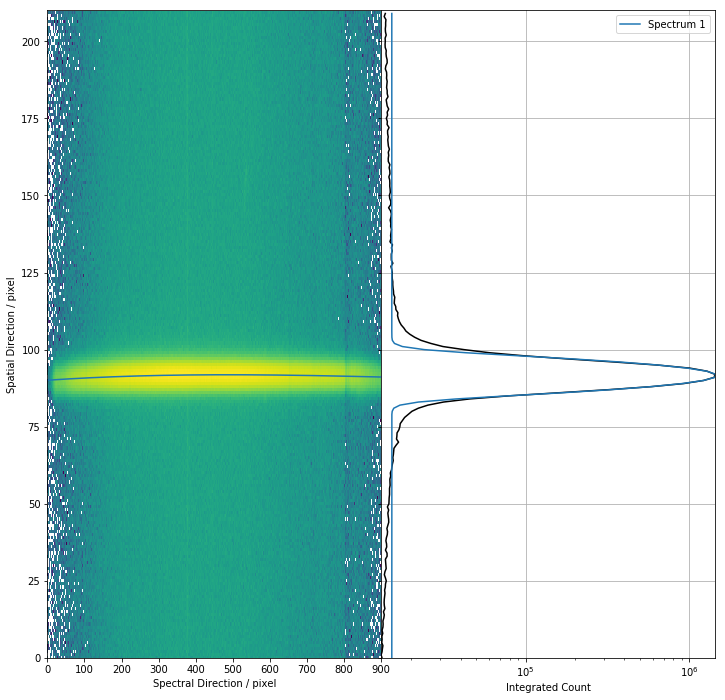

In [4]:
# (3) example of twodspec.ap_trace() with cosmic ray removal, selecting the 7 brightest spectra
#     in the pixel range covered by spatial_mask and spec_mask.
#     The 6th and 7th ones failed, error messages are printed but the code continues to run.

spatial_mask = np.arange(40,250)
spec_mask = np.arange(100,1000)

my, my_sigma = twodspec.ap_trace(sprat_data, nsteps=20, Saxis=1, spatial_mask=spatial_mask, spec_mask=spec_mask,
                                cosmic=True, n_spec=1, recenter=False, prevtrace=(0, ), 
                                fittype='cubic', bigbox=8, silence=True, display=True)

aspired/twodspec.py:644: RuntimeWarning: invalid value encountered in log10
  min(median_trace+widthup+skysep+skywidth, len(img[0])), :]),


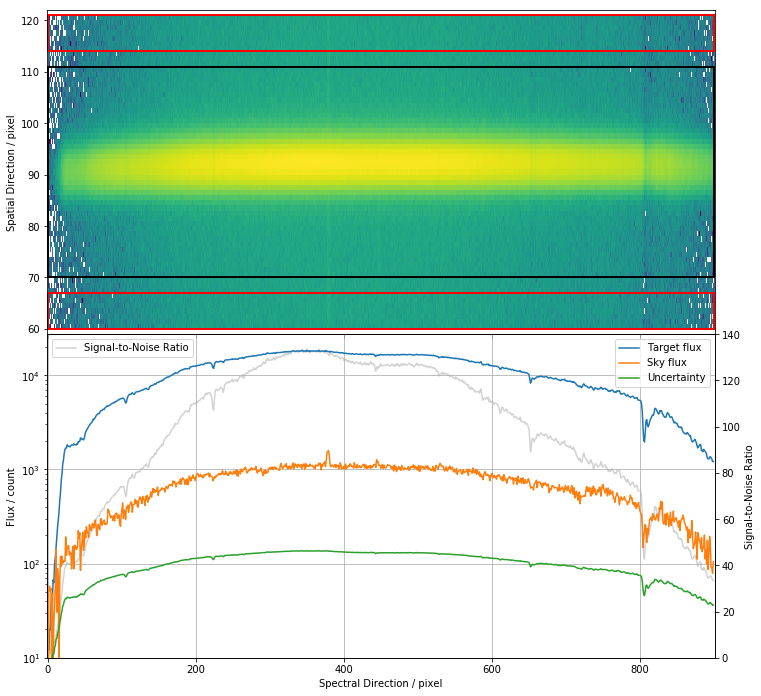

In [5]:
# (4b) (Optimal) Extracting spectrum by summing over the aperture along the trace
# my[0] is a special cases where skysep has to be increased to avoid crowding
spec, sky, err = twodspec.ap_extract(
    sprat_data,
    my[0],
    apwidth=20,
    trace_sigma = my_sigma[0],
    spatial_mask=spatial_mask,
    spec_mask=spec_mask,
    display=True)

/usr/local/lib/python3.7/site-packages/matplotlib/axes/_base.py:3455: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


(array([3200., 3201., 3202., ..., 9196., 9198., 9200.]),
 array([6.8253e-13, 6.8022e-13, 6.7979e-13, ..., 3.1712e-14, 3.1495e-14,
        3.1336e-14]))

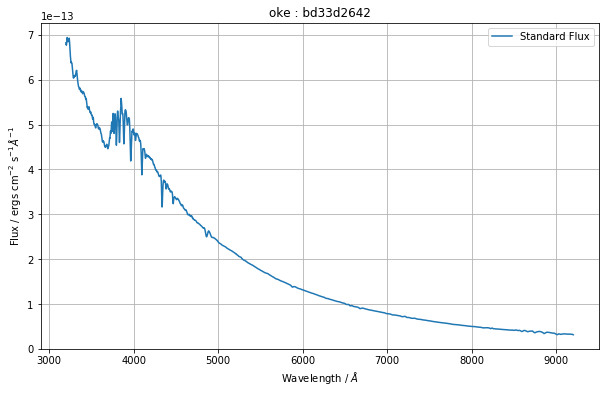

In [6]:
standard._read_standard('bd33d2642' ,'oke', 'flux', display=True)

/usr/local/lib/python3.7/site-packages/scipy/signal/_savitzky_golay.py:135: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  coeffs, _, _, _ = lstsq(A, y)
/usr/local/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


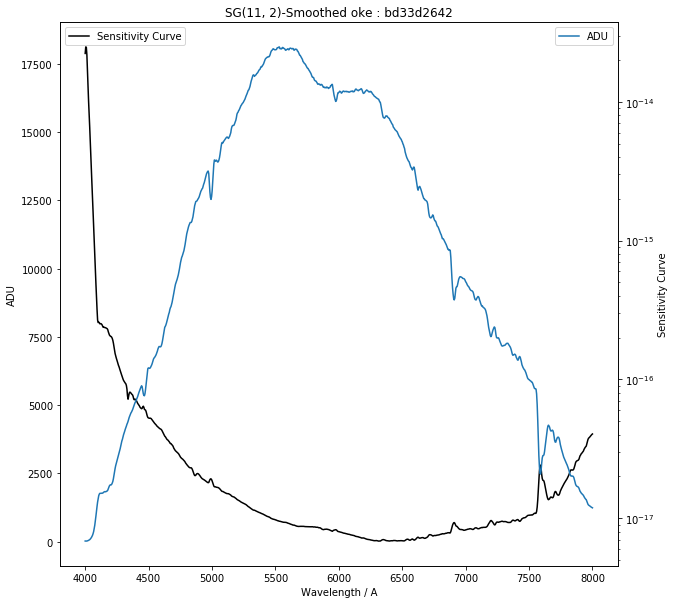

In [7]:
# Get the standard
standard_wave, standard_flux = standard._read_standard('bd33d2642' ,'oke', 'flux', display=False)

# Get the sensitivity curves with and without smoothing
wave = np.arange(len(spec))*4.45+4000.
sencurve_smoothed = standard.get_sencurve(wave, spec, 'bd33d2642' ,'oke', slength=11, sorder=2, display=True)


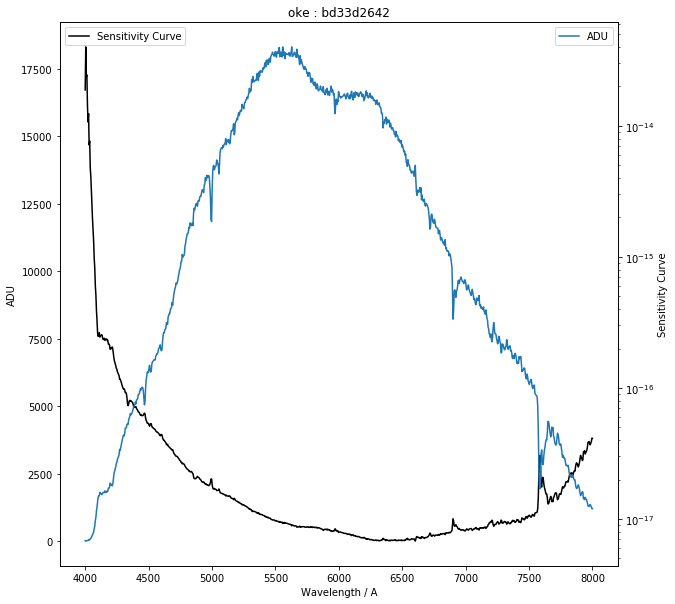

In [8]:
sencurve_not_smoothed = standard.get_sencurve(wave, spec, 'bd33d2642' ,'oke', smooth=False, display=True)

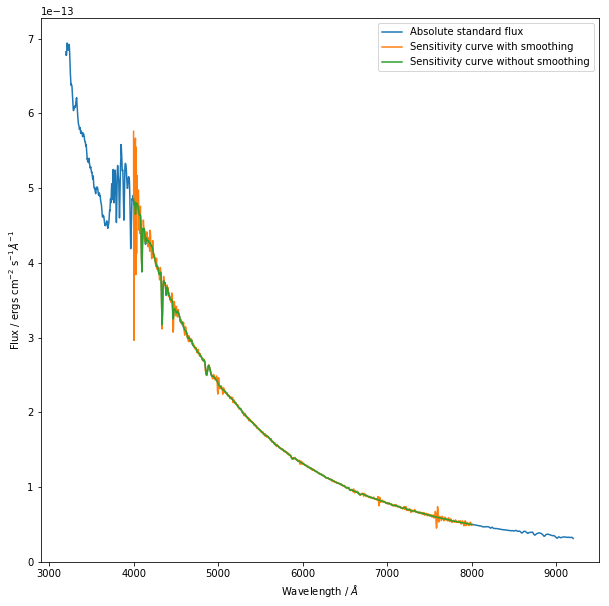

In [9]:
# Plot the three spectra
plt.figure(figsize=(10,10))
plt.plot(standard_wave, standard_flux, label='Absolute standard flux')
plt.plot(wave, spec * sencurve_smoothed(wave), label='Sensitivity curve with smoothing')
plt.plot(wave, spec * sencurve_not_smoothed(wave), label='Sensitivity curve without smoothing')
plt.xlabel(r'Wavelength / $\AA$')
plt.ylabel(r'Flux / ergs cm$^{-2}$ s$^{-1} \AA^{-1}$')
plt.ylim(ymin=0)
plt.ylim(ymin=0)
plt.legend()